In [18]:
import librosa
import os
import numpy as np

from dtw import dtw
from numpy.linalg import norm
from numpy import array
import pyaudio
import wave

import heapq

In [2]:
def initialCorpus(path):
    # 音乐库位置
    audioList = os.listdir(path)

    raw_audioList = {}
    beat_database = {}

    for tmp in audioList:
        audioName = os.path.join(path, tmp)
        if audioName.endswith('.wav'):
            y, sr = librosa.load(audioName)
            # 跟踪歌曲的节奏点
            tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
            # 对提取的节奏序列进行差分
            beat_frames = librosa.feature.delta(beat_frames)
            # 存入数据表
            beat_database[audioName] = beat_frames

    # 保存音乐节奏数据库
    np.save('beatDatabase.npy', beat_database)
    
    return beat_database

In [5]:
def readCorpus(path):
    
    # 读入音乐节奏数据库
    all_data = np.load(path, allow_pickle=True)
    beat_database = all_data.item()
    
    return beat_database

In [47]:
def updateCorpus(path, dbpath):
    
    # 音乐库位置
    audioList = os.listdir(path)
    
    # 已保存序列的文件
    raw_db = readCorpus(dbPath)
    raw_files = raw_db.keys()
    
    for tmp in audioList:
        audioName = os.path.join(path, tmp)
        if audioName.endswith('.wav') and audioName not in raw_files:
            y, sr = librosa.load(audioName)
            # 跟踪歌曲的节奏点
            tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
            # 对提取的节奏序列进行差分
            beat_frames = librosa.feature.delta(beat_frames)
            # 存入数据表
            beat_database[audioName] = beat_frames

    # 保存音乐节奏数据库
    np.save(dbpath, beat_database)

In [91]:
def voiceCompare_quick(dbPath, tPath):
    
    # 读入语料库
    all_data = np.load(dbPath, allow_pickle=True)
    beat_database = all_data.item()

    # 读入要识别的录音
    y, sr = librosa.load(tPath)

    # 识别录音的节奏序列
    tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
    beat_frames = librosa.feature.delta(beat_frames,mode ='nearest')
    x = array(beat_frames).reshape(-1, 1)

    # 将待识别的录音序列与语料库中语音逐一做DTW对比
    compare_result = {}
    
    for songID in beat_database.keys():
        y = beat_database[songID]
        y = array(y).reshape(-1, 1)
        
        dist = dtw(x, y).distance
        # print('两段话的差异程度为： ', songID.split("\\")[1], ": ", dist)
        
        compare_result[songID] = dist

    matched_song = min(compare_result, key=compare_result.get)
    print("最接近的录音是：", matched_song)

In [103]:
from sklearn import preprocessing

def voiceCompare(dbPath, tPath):
    
    # 读入语料库
    all_data = np.load(dbPath, allow_pickle=True)
    beat_database = all_data.item()

    # 读入要识别的录音
    y, sr = librosa.load(tPath)

    # 识别录音的节奏序列
    tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
    beat_frames = librosa.feature.delta(beat_frames)
    x = array(beat_frames).reshape(-1, 1)
    
    x = preprocessing.minmax_scale(x)
    
    lenx = len(x)

    # 将待识别的录音序列与语料库中语音逐一做DTW对比
    # compare_result = {}
    heap = []
    heapq.heapify(heap)  # 栈 for [dist, 时间段，文件名]
    
    for songID in beat_database.keys():
        y = beat_database[songID]
        y = array(y).reshape(-1, 1)
        # print(leny)
        leny = len(y)
        print(leny)
        
        for tp in range(0, leny - lenx):
            sliY =  preprocessing.minmax_scale(y[tp : tp + lenx])
            
            dist = dtw(x, sliY).distance
            
            tupleY = (dist, tp, songID)
            heapq.heappush(heap, tupleY)
            
            if (songID == './corpus\\00415250.wav'):
                print(dist, tp)
                print(sliY)
        
        # dist = dtw(x, y).distance
        # print('两段话的差异程度为： ', songID.split("\\")[1], ": ", dist)
        
        # compare_result[songID] = dist

    #  matched_song = min(compare_result, key=compare_result.get)
    # print("最接近的录音是：", matched_song)
    return heap

In [104]:
# 语料库路径
corpus_path = './corpus'

# 数据表路径
dbPath = './beatDatabase.npy';

In [105]:
# 初始化语料序列库
# beatDB = initialCorpus(corpus_path)

# 更新语料库中新音乐文件的序列
# updateCorpus(corpus_path, dbPath)

# 读入语料序列库
# beat_database = readCorpus(dbPath)

# 识别输入录音

# test file path
testPath = './input/00415250-前5s.wav'

vheap = voiceCompare(dbPath, testPath)

146
0.9221170395869152 0
[[1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.81927711]
 [0.57831325]
 [0.36144578]
 [0.14457831]
 [0.        ]
 [0.19277108]]
1.295611015490529 1
[[1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.81927711]
 [0.57831325]
 [0.36144578]
 [0.14457831]
 [0.        ]
 [0.19277108]
 [0.37349398]]
1.8739242685025737 2
[[1.        ]
 [1.        ]
 [1.        ]
 [0.81927711]
 [0.57831325]
 [0.36144578]
 [0.14457831]
 [0.        ]
 [0.19277108]
 [0.37349398]
 [0.57831325]]
2.72934595524956 3
[[1.        ]
 [1.        ]
 [0.81927711]
 [0.57831325]
 [0.36144578]
 [0.14457831]
 [0.        ]
 [0.19277108]
 [0.37349398]
 [0.57831325]
 [0.85542169]]
3.9515873015872813 4
[[0.92222222]
 [0.75555556]
 [0.53333333]
 [0.33333333]
 [0.13333333]
 [0.        ]
 [0.17777778]
 [0.34444444]
 [0.53333333]
 [0.78888889]
 [1.        ]]
5.801317614424402 5
[[0.66019417]
 [0.46601942]
 [0.29126214]
 [0.11650485]
 [0.        ]
 [0.15533981]
 [0.30097087]
 

672
327
315
251
649
486
188
367
143


In [102]:
px

array([[0.06810036],
       [0.390681  ],
       [0.6827957 ],
       [0.89784946],
       [1.        ],
       [0.97670251],
       [0.94982079],
       [0.80645161],
       [0.57885305],
       [0.29928315],
       [0.        ]])

In [97]:
vheap

[(0.039682539682551976, 607, './corpus\\00432299.wav'),
 (0.0714285714285765, 24, './corpus\\00432299.wav'),
 (0.5128032345013658, 0, './corpus\\00433233.wav'),
 (0.21428571428568688, 27, './corpus\\00432299.wav'),
 (0.18253968253969077, 275, './corpus\\00432299.wav'),
 (0.5642857142857238, 64, './corpus\\00433233.wav'),
 (0.7214285714285857, 127, './corpus\\00429881.wav'),
 (0.404761904761898, 23, './corpus\\00432299.wav'),
 (0.344155844155857, 444, './corpus\\00432299.wav'),
 (0.21428571428568688, 548, './corpus\\00432299.wav'),
 (0.20129870129871819, 211, './corpus\\00432701.wav'),
 (0.564285714285738, 22, './corpus\\00432299.wav'),
 (0.6255411255410905, 69, './corpus\\00433664.wav'),
 (0.8344155844154759, 367, './corpus\\00429126.wav'),
 (0.7704081632652944, 126, './corpus\\00430105.wav'),
 (0.4642857142857224, 25, './corpus\\00432299.wav'),
 (0.4298029556650391, 274, './corpus\\00432299.wav'),
 (0.8780788177339858, 329, './corpus\\00432299.wav'),
 (0.3642857142857281, 443, './corp

In [98]:
for i in range(0, len(vheap)):
    if (vheap[i][2] == './corpus\\00415250.wav'):
        print(vheap[i])

(1.1532738095238049, 50, './corpus\\00415250.wav')
(1.4228110599078363, 122, './corpus\\00415250.wav')
(1.5396825396825502, 119, './corpus\\00415250.wav')
(1.194622792937409, 41, './corpus\\00415250.wav')
(1.226190476190478, 45, './corpus\\00415250.wav')
(1.1220238095238084, 49, './corpus\\00415250.wav')
(2.324404761904791, 99, './corpus\\00415250.wav')
(1.2902255639097824, 47, './corpus\\00415250.wav')
(1.4849042709867373, 104, './corpus\\00415250.wav')
(1.4228110599078345, 120, './corpus\\00415250.wav')
(3.80519480519483, 34, './corpus\\00415250.wav')
(2.6240920096851887, 78, './corpus\\00415250.wav')
(1.314960629921238, 81, './corpus\\00415250.wav')
(1.4063146997929383, 82, './corpus\\00415250.wav')
(1.2573529411764461, 83, './corpus\\00415250.wav')
(1.1961770623742503, 52, './corpus\\00415250.wav')
(1.678571428571452, 54, './corpus\\00415250.wav')
(7.923645320197032, 111, './corpus\\00415250.wav')
(3.4782608695652257, 27, './corpus\\00415250.wav')
(1.8739242685025737, 2, './corpus\

In [99]:
heapq.nsmallest(10, vheap)

[(0.039682539682551976, 607, './corpus\\00432299.wav'),
 (0.0714285714285765, 24, './corpus\\00432299.wav'),
 (0.18253968253969077, 275, './corpus\\00432299.wav'),
 (0.20129870129871819, 211, './corpus\\00432701.wav'),
 (0.21428571428568688, 27, './corpus\\00432299.wav'),
 (0.21428571428568688, 548, './corpus\\00432299.wav'),
 (0.34415584415584277, 116, './corpus\\00432701.wav'),
 (0.344155844155857, 444, './corpus\\00432299.wav'),
 (0.35317460317463656, 549, './corpus\\00432299.wav'),
 (0.3642857142857281, 443, './corpus\\00432299.wav')]

[ 2.1489237e-09 -1.6664818e-10 -2.8525275e-09 ... -8.7864893e-05
 -7.1389615e-05  0.0000000e+00]


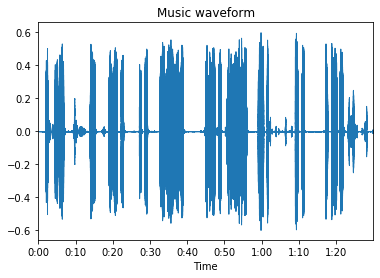

In [89]:
# # 绘图显示
# import librosa.display
# import matplotlib.pyplot as plt

# audioName = "./input/00415250.wav"
# y, sr = librosa.load(audioName)
# beat_frames = librosa.feature.delta(beat_frames,mode ='nearest')
#     x = array(beat_frames).reshape(-1, 1)
# print(y)
# # 绘制声音波形
# plt.figure()
# librosa.display.waveplot(y, sr)
# plt.title('Music waveform')
# plt.show()

In [161]:
audioName = "./input/00415250.wav"
y, sr = librosa.load(audioName, sr=None)
# tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
# beat_frames = librosa.feature.delta(beat_frames)
# x = array(beat_frames).reshape(-1, 1)

f1 = librosa.feature.mfcc(y=y, sr=sr)

In [163]:
f1

array([[-5.6671179e+02, -5.6671179e+02, -5.6671179e+02, ...,
        -4.5843448e+02, -4.9652750e+02, -5.3048840e+02],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         1.7363564e+01,  4.6757931e+01,  4.1016754e+01],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -2.4665920e+01, -3.6458092e+00,  1.9531054e+01],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -2.4816517e+01, -1.2844425e+01, -7.4394493e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -7.0713158e+00, -1.2559330e+01,  5.4400861e-01],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         1.7620926e+01,  8.2181101e+00,  1.3924236e+01]], dtype=float32)

In [168]:
print(np.size(f1, 0), np.size(f1, 1))

20 1407


In [172]:
len(y)

719999

In [169]:
audioName = "./input/00415250-前5s.wav"
y2, sr2 = librosa.load(audioName, sr=None)
# tempo, beat_frames = librosa.beat.beat_track(y=y2, sr=sr2)
#beat_frames = librosa.feature.delta(beat_frames)
#x = array(beat_frames).reshape(-1, 1)

f2 = librosa.feature.mfcc(y=y2, sr=sr2)

In [171]:
print(np.size(f2, 0), np.size(f2, 1))

20 479


In [174]:
len(y2)

244736

In [ ]:
ptint

In [160]:
for i in range(0, 30000):
    if (y[i] != y2[i]):
        print(i,":", y[i] - y2[i])

0 : -1.5258789e-05
7 : 1.5258789e-05
8 : 1.5258789e-05
13 : -1.5258789e-05
14 : -3.0517578e-05
15 : -3.0517578e-05
16 : -3.0517578e-05
17 : -1.5258789e-05
18 : -1.5258789e-05
19 : -1.5258789e-05
20 : -1.5258789e-05
21 : -1.5258789e-05
22 : -1.5258789e-05
24 : -1.5258789e-05
25 : -1.5258789e-05
26 : -1.5258789e-05
28 : -1.5258789e-05
29 : -1.5258789e-05
37 : -1.5258789e-05
38 : -1.5258789e-05
39 : -1.5258789e-05
40 : -1.5258789e-05
41 : -1.5258789e-05
42 : -1.5258789e-05
45 : 1.5258789e-05
46 : 3.0517578e-05
47 : 4.5776367e-05
48 : 6.1035156e-05
49 : 6.1035156e-05
50 : 1.5258789e-05
51 : 7.6293945e-05
52 : -1.5258789e-05
53 : 1.5258789e-05
54 : -3.0517578e-05
55 : -4.5776367e-05
56 : -6.1035156e-05
57 : -6.1035156e-05
58 : -6.1035156e-05
59 : -9.1552734e-05
60 : -4.5776367e-05
61 : -3.0517578e-05
62 : -1.5258789e-05
63 : -1.5258789e-05
65 : 4.5776367e-05
66 : 1.5258789e-05
67 : 6.1035156e-05
68 : 4.5776367e-05
69 : 6.1035156e-05
70 : 7.6293945e-05
71 : 4.5776367e-05
72 : 7.6293945e-05
7

1302 : 6.1035156e-05
1303 : 0.00012207031
1304 : 0.00016784668
1305 : 0.00015258789
1306 : 0.00012207031
1307 : 0.00015258789
1308 : 0.0001373291
1309 : 0.00010681152
1310 : 7.6293945e-05
1312 : -4.5776367e-05
1313 : -0.00012207031
1314 : -0.00012207031
1315 : -0.0001373291
1316 : -0.0001373291
1317 : -0.0001373291
1318 : -7.6293945e-05
1319 : -1.5258789e-05
1320 : 1.5258789e-05
1321 : 0.0001373291
1322 : 0.00012207031
1323 : 7.6293945e-05
1324 : 0.00010681152
1325 : 6.1035156e-05
1326 : -1.5258789e-05
1327 : -7.6293945e-05
1328 : -0.00012207031
1329 : -0.00016784668
1330 : -0.0001373291
1331 : -0.00016784668
1332 : -0.00010681152
1333 : 1.5258789e-05
1334 : 3.0517578e-05
1335 : 7.6293945e-05
1336 : 7.6293945e-05
1337 : 0.00015258789
1338 : 0.00012207031
1339 : 4.5776367e-05
1341 : -4.5776367e-05
1342 : -0.0001373291
1343 : -0.00015258789
1344 : -0.00012207031
1345 : -0.0001373291
1346 : -9.1552734e-05
1347 : -1.5258789e-05
1348 : 4.5776367e-05
1349 : 0.00012207031
1350 : 0.00016784668

2564 : 0.00015258789
2565 : 4.5776367e-05
2566 : -1.5258789e-05
2567 : -4.5776367e-05
2568 : -0.00015258789
2569 : -0.0001373291
2570 : -0.00016784668
2571 : -0.00012207031
2572 : -0.00012207031
2574 : 3.0517578e-05
2575 : 3.0517578e-05
2576 : 4.5776367e-05
2579 : -6.1035156e-05
2580 : -6.1035156e-05
2581 : -9.1552734e-05
2582 : -0.00010681152
2583 : -9.1552734e-05
2584 : -0.00010681152
2585 : -3.0517578e-05
2586 : 3.0517578e-05
2587 : 6.1035156e-05
2588 : 0.00010681152
2589 : 0.0001373291
2590 : 0.00016784668
2591 : 0.00012207031
2592 : 7.6293945e-05
2593 : 7.6293945e-05
2594 : 3.0517578e-05
2595 : 1.5258789e-05
2596 : 1.5258789e-05
2597 : -1.5258789e-05
2598 : 6.1035156e-05
2601 : 4.5776367e-05
2602 : -1.5258789e-05
2603 : -3.0517578e-05
2604 : -7.6293945e-05
2605 : -0.00010681152
2606 : -0.0001373291
2607 : -9.1552734e-05
2608 : -6.1035156e-05
2610 : 4.5776367e-05
2611 : 0.00010681152
2612 : 0.0001373291
2613 : 0.00012207031
2614 : 0.00010681152
2615 : 3.0517578e-05
2616 : 4.5776367

3984 : 0.00076293945
3985 : 0.0008087158
3986 : 0.00079345703
3987 : 0.00074768066
3988 : 0.00064086914
3989 : 0.0005645752
3990 : 0.00036621094
3991 : 0.00019836426
3993 : -0.00018310547
3994 : -0.00032043457
3995 : -0.0004272461
3996 : -0.00048828125
3997 : -0.00047302246
3998 : -0.0004272461
3999 : -0.0004119873
4000 : -0.0002746582
4001 : -0.00015258789
4002 : -9.1552734e-05
4003 : -4.5776367e-05
4006 : -1.5258789e-05
4007 : -3.0517578e-05
4008 : -3.0517578e-05
4009 : -6.1035156e-05
4010 : -6.1035156e-05
4011 : -6.1035156e-05
4013 : 4.5776367e-05
4014 : 0.00012207031
4015 : 0.00015258789
4016 : 0.00012207031
4017 : 0.00012207031
4018 : 0.00012207031
4019 : 9.1552734e-05
4020 : -1.5258789e-05
4022 : -4.5776367e-05
4023 : -0.00010681152
4024 : -6.1035156e-05
4025 : -6.1035156e-05
4026 : -3.0517578e-05
4027 : 7.6293945e-05
4028 : 0.00015258789
4029 : 0.00022888184
4030 : 0.00035095215
4031 : 0.00044250488
4032 : 0.00045776367
4033 : 0.00050354004
4034 : 0.00050354004
4035 : 0.00051879

5328 : 0.0030059814
5329 : 0.003112793
5330 : 0.0031738281
5331 : 0.003326416
5332 : 0.00340271
5333 : 0.0035095215
5334 : 0.0036468506
5335 : 0.0037231445
5336 : 0.0038604736
5337 : 0.0039520264
5338 : 0.0040130615
5339 : 0.0041046143
5340 : 0.0040893555
5341 : 0.0040283203
5342 : 0.0040283203
5343 : 0.0038452148
5344 : 0.0036468506
5345 : 0.0034332275
5346 : 0.0030822754
5347 : 0.0027008057
5348 : 0.0022583008
5349 : 0.0017700195
5350 : 0.0012359619
5351 : 0.0006713867
5352 : 7.6293945e-05
5353 : -0.0005340576
5354 : -0.0011444092
5355 : -0.0017547607
5356 : -0.0023345947
5357 : -0.00289917
5358 : -0.00340271
5359 : -0.0038909912
5360 : -0.0043182373
5361 : -0.0046691895
5362 : -0.0049591064
5363 : -0.0051727295
5364 : -0.0053253174
5365 : -0.0054016113
5366 : -0.00541687
5367 : -0.005355835
5368 : -0.0052337646
5369 : -0.005065918
5370 : -0.004852295
5371 : -0.0046081543
5372 : -0.004272461
5373 : -0.003921509
5374 : -0.0035552979
5375 : -0.003112793
5376 : -0.0027313232
5377 : -0.0

6829 : -0.020126343
6830 : -0.018310547
6831 : -0.016235352
6832 : -0.013946533
6833 : -0.011581421
6834 : -0.009124756
6835 : -0.006866455
6836 : -0.0045776367
6837 : -0.0026245117
6838 : -0.00093078613
6839 : 0.0005493164
6840 : 0.0018005371
6841 : 0.002609253
6842 : 0.0032806396
6843 : 0.0036315918
6844 : 0.0036468506
6845 : 0.0036773682
6846 : 0.0034484863
6847 : 0.0030517578
6848 : 0.0026855469
6849 : 0.002090454
6850 : 0.0015563965
6851 : 0.0010986328
6852 : 0.00065612793
6853 : 0.00045776367
6854 : 0.00030517578
6855 : 0.00035095215
6856 : 0.0007324219
6857 : 0.0012969971
6858 : 0.0020599365
6859 : 0.003112793
6860 : 0.0043182373
6861 : 0.0056915283
6862 : 0.0071258545
6863 : 0.008621216
6864 : 0.010070801
6865 : 0.011459351
6866 : 0.012664795
6867 : 0.013641357
6868 : 0.014419556
6869 : 0.014892578
6870 : 0.015151978
6871 : 0.014968872
6872 : 0.014541626
6873 : 0.013809204
6874 : 0.012771606
6875 : 0.011383057
6876 : 0.009735107
6877 : 0.0078125
6878 : 0.0056152344
6879 : 0.003

8162 : 0.04283142
8163 : 0.034454346
8164 : 0.025360107
8165 : 0.015411377
8166 : 0.004928589
8167 : -0.0056610107
8168 : -0.016235352
8169 : -0.026351929
8170 : -0.03553772
8171 : -0.0438385
8172 : -0.051101685
8173 : -0.05709839
8174 : -0.062072754
8175 : -0.06588745
8176 : -0.06877136
8177 : -0.07054138
8178 : -0.071136475
8179 : -0.070739746
8180 : -0.069000244
8181 : -0.06616211
8182 : -0.06225586
8183 : -0.057281494
8184 : -0.051452637
8185 : -0.045059204
8186 : -0.038223267
8187 : -0.03111267
8188 : -0.024032593
8189 : -0.016967773
8190 : -0.010070801
8191 : -0.0033416748
8192 : 0.003326416
8193 : 0.009811401
8194 : 0.016021729
8195 : 0.022201538
8196 : 0.027801514
8197 : 0.03303528
8198 : 0.037582397
8199 : 0.041427612
8200 : 0.044448853
8201 : 0.046585083
8202 : 0.04789734
8203 : 0.048324585
8204 : 0.04827881
8205 : 0.04763794
8206 : 0.0466156
8207 : 0.045196533
8208 : 0.043548584
8209 : 0.041534424
8210 : 0.03919983
8211 : 0.036590576
8212 : 0.033615112
8213 : 0.03036499
8214

9598 : 0.021713257
9599 : 0.02557373
9600 : 0.029632568
9601 : 0.03404236
9602 : 0.03878784
9603 : 0.043945312
9604 : 0.0496521
9605 : 0.055862427
9606 : 0.06265259
9607 : 0.069747925
9608 : 0.07698059
9609 : 0.08451843
9610 : 0.09188843
9611 : 0.09893799
9612 : 0.10551453
9613 : 0.11123657
9614 : 0.11592102
9615 : 0.11924744
9616 : 0.120895386
9617 : 0.1207428
9618 : 0.11854553
9619 : 0.114227295
9620 : 0.10746765
9621 : 0.098526
9622 : 0.087509155
9623 : 0.07461548
9624 : 0.06021118
9625 : 0.044387817
9626 : 0.02758789
9627 : 0.010299683
9628 : -0.0073547363
9629 : -0.025131226
9630 : -0.042526245
9631 : -0.05958557
9632 : -0.07608032
9633 : -0.09162903
9634 : -0.10618591
9635 : -0.11959839
9636 : -0.1315155
9637 : -0.14199829
9638 : -0.15054321
9639 : -0.15699768
9640 : -0.16134644
9641 : -0.16329956
9642 : -0.16314697
9643 : -0.16070557
9644 : -0.15653992
9645 : -0.15081787
9646 : -0.14334106
9647 : -0.13468933
9648 : -0.12503052
9649 : -0.11451721
9650 : -0.10310364
9651 : -0.0907

10995 : -0.113723755
10996 : -0.090545654
10997 : -0.06486511
10998 : -0.037200928
10999 : -0.007949829
11000 : 0.022277832
11001 : 0.05290222
11002 : 0.08328247
11003 : 0.11286926
11004 : 0.14105225
11005 : 0.1676178
11006 : 0.19204712
11007 : 0.21414185
11008 : 0.23365784
11009 : 0.25024414
11010 : 0.26367188
11011 : 0.2735901
11012 : 0.27989197
11013 : 0.2823639
11014 : 0.28097534
11015 : 0.27593994
11016 : 0.26748657
11017 : 0.256073
11018 : 0.24215698
11019 : 0.22608948
11020 : 0.20843506
11021 : 0.1894226
11022 : 0.16918945
11023 : 0.14781189
11024 : 0.12548828
11025 : 0.10221863
11026 : 0.07815552
11027 : 0.053710938
11028 : 0.02923584
11029 : 0.005279541
11030 : -0.017562866
11031 : -0.03894043
11032 : -0.05822754
11033 : -0.07531738
11034 : -0.0900116
11035 : -0.10244751
11036 : -0.11294556
11037 : -0.12161255
11038 : -0.12869263
11039 : -0.13449097
11040 : -0.13899231
11041 : -0.14204407
11042 : -0.14376831
11043 : -0.14372253
11044 : -0.14187622
11045 : -0.1381073
11046 : -0

12411 : -4.5776367e-05
12412 : -0.00015258789
12413 : -0.0002746582
12414 : -0.00035095215
12415 : -0.00048828125
12416 : -0.0004119873
12417 : -0.00030517578
12418 : -0.00019836426
12419 : -6.1035156e-05
12420 : -0.00012207031
12421 : -0.0001373291
12422 : -0.00036621094
12423 : -0.00076293945
12424 : -0.0012817383
12425 : -0.0018463135
12426 : -0.002319336
12427 : -0.0027313232
12428 : -0.0028381348
12429 : -0.0027923584
12430 : -0.0024414062
12431 : -0.0018005371
12432 : -0.0010528564
12433 : -0.00022888184
12434 : 0.0005645752
12435 : 0.0012359619
12436 : 0.001663208
12437 : 0.0017242432
12438 : 0.001739502
12439 : 0.0014801025
12440 : 0.0010681152
12441 : 0.0008239746
12442 : 0.00062561035
12443 : 0.00064086914
12444 : 0.0008392334
12445 : 0.0011444092
12446 : 0.0014801025
12447 : 0.0018615723
12448 : 0.0021820068
12449 : 0.0022277832
12450 : 0.0022277832
12451 : 0.0020141602
12452 : 0.0017547607
12453 : 0.001373291
12454 : 0.0009460449
12455 : 0.0006713867
12456 : 0.00033569336
1

13816 : -0.009475708
13817 : -0.0061035156
13818 : -0.0030670166
13819 : 6.1035156e-05
13820 : 0.0031585693
13821 : 0.005569458
13822 : 0.008224487
13823 : 0.010635376
13824 : 0.012283325
13825 : 0.013656616
13826 : 0.014526367
13827 : 0.01449585
13828 : 0.0137786865
13829 : 0.012817383
13830 : 0.010635376
13831 : 0.008651733
13832 : 0.006088257
13833 : 0.0036621094
13834 : 0.0015106201
13835 : -0.0007171631
13836 : -0.0020599365
13837 : -0.0033721924
13838 : -0.003479004
13839 : -0.004425049
13840 : -0.0041046143
13841 : -0.003479004
13842 : -0.0036468506
13843 : -0.0025482178
13844 : -0.0020599365
13845 : -0.0011749268
13846 : 0.00015258789
13847 : 0.0015106201
13848 : 0.002609253
13849 : 0.005050659
13850 : 0.0070495605
13851 : 0.008468628
13852 : 0.010925293
13853 : 0.0126953125
13854 : 0.01399231
13855 : 0.014556885
13856 : 0.015106201
13857 : 0.014709473
13858 : 0.013381958
13859 : 0.011734009
13860 : 0.009216309
13861 : 0.0066833496
13862 : 0.0034179688
13863 : -0.00038146973
13

15188 : 0.008743286
15189 : -0.029556274
15190 : -0.049682617
15191 : -0.05769348
15192 : -0.058654785
15193 : -0.061813354
15194 : -0.060943604
15195 : -0.048187256
15196 : -0.0181427
15197 : 0.005203247
15198 : 0.008972168
15199 : -0.006881714
15200 : -0.034439087
15201 : -0.050094604
15202 : -0.057510376
15203 : -0.04437256
15204 : -0.019836426
15205 : 0.0054626465
15206 : 0.02520752
15207 : 0.027938843
15208 : 0.01927185
15209 : 0.018341064
15210 : 0.047790527
15211 : 0.095962524
15212 : 0.10467529
15213 : 0.023086548
15214 : -0.11393738
15215 : -0.21542358
15216 : -0.20204163
15217 : -0.0639801
15218 : 0.090789795
15219 : 0.15335083
15220 : 0.10057068
15221 : -0.021499634
15222 : -0.105270386
15223 : -0.109191895
15224 : -0.079193115
15225 : -0.07322693
15226 : -0.126297
15227 : -0.18972778
15228 : -0.20533752
15229 : -0.1374054
15230 : -0.029846191
15231 : 0.04336548
15232 : 0.049987793
15233 : 0.0019378662
15234 : -0.04534912
15235 : -0.057662964
15236 : -0.028381348
15237 : 0.0

16688 : 0.06568909
16689 : 0.06060791
16690 : 0.04258728
16691 : 0.064575195
16692 : 0.09466553
16693 : 0.13542175
16694 : 0.14715576
16695 : 0.04084778
16696 : -0.08355713
16697 : -0.12788391
16698 : -0.08078003
16699 : 0.06813049
16700 : 0.21714783
16701 : 0.25776672
16702 : 0.21890259
16703 : 0.14483643
16704 : 0.08325195
16705 : 0.08631897
16706 : 0.11550903
16707 : 0.11186218
16708 : 0.090286255
16709 : 0.06896973
16710 : 0.11566162
16711 : 0.23370361
16712 : 0.31625366
16713 : 0.31655884
16714 : 0.21987915
16715 : 0.08229065
16716 : -0.00869751
16717 : -0.014465332
16718 : 0.024353027
16719 : 0.063430786
16720 : 0.06690979
16721 : 0.018478394
16722 : -0.028823853
16723 : -0.048614502
16724 : -0.05218506
16725 : -0.05117798
16726 : -0.07827759
16727 : -0.22261047
16728 : -0.3795166
16729 : -0.43836975
16730 : -0.4043579
16731 : -0.25297546
16732 : -0.11260986
16733 : -0.0778656
16734 : -0.12416077
16735 : -0.20227051
16736 : -0.26020813
16737 : -0.2500763
16738 : -0.21151733
16739

18188 : 0.124938965
18189 : 0.24281311
18190 : 0.39056396
18191 : 0.45721436
18192 : 0.21766663
18193 : -0.000579834
18194 : 0.12045288
18195 : 0.22164917
18196 : -0.014541626
18197 : -0.24588013
18198 : -0.17330933
18199 : 0.010879517
18200 : 0.030014038
18201 : -0.14736938
18202 : -0.27947998
18203 : -0.23527527
18204 : -0.17166138
18205 : -0.27085876
18206 : -0.41178894
18207 : -0.4088745
18208 : -0.29766846
18209 : -0.19691467
18210 : -0.1842041
18211 : -0.1430664
18212 : -0.015731812
18213 : 0.05744934
18214 : -0.011123657
18215 : 0.07443237
18216 : 0.24484253
18217 : -0.04020691
18218 : -0.3604889
18219 : -0.15908813
18220 : 0.051101685
18221 : -0.14021301
18222 : -0.2743988
18223 : -0.15127563
18224 : -0.008911133
18225 : 0.16769409
18226 : 0.1929779
18227 : -0.072402954
18228 : -0.17280579
18229 : 0.110198975
18230 : 0.18920898
18231 : -0.12652588
18232 : -0.29034424
18233 : -0.08602905
18234 : 0.15969849
18235 : 0.15135193
18236 : -0.035858154
18237 : -0.11743164
18238 : 0.052

19688 : -0.040649414
19689 : -0.07847595
19690 : -0.111846924
19691 : -0.14302063
19692 : -0.17427063
19693 : -0.19779968
19694 : -0.21876526
19695 : -0.24261475
19696 : -0.25408936
19697 : -0.26991272
19698 : -0.28056335
19699 : -0.28735352
19700 : -0.29533386
19701 : -0.29885864
19702 : -0.29989624
19703 : -0.29615784
19704 : -0.2934723
19705 : -0.28204346
19706 : -0.27127075
19707 : -0.2550354
19708 : -0.23280334
19709 : -0.20994568
19710 : -0.18232727
19711 : -0.15185547
19712 : -0.121917725
19713 : -0.0892334
19714 : -0.055221558
19715 : -0.02696228
19716 : 0.006958008
19717 : 0.035003662
19718 : 0.062683105
19719 : 0.08958435
19720 : 0.11619568
19721 : 0.14338684
19722 : 0.16362
19723 : 0.18916321
19724 : 0.21096802
19725 : 0.23051453
19726 : 0.24681091
19727 : 0.26524353
19728 : 0.27764893
19729 : 0.28260803
19730 : 0.2878723
19731 : 0.28512573
19732 : 0.2780609
19733 : 0.26235962
19734 : 0.24481201
19735 : 0.22027588
19736 : 0.18913269
19737 : 0.15715027
19738 : 0.12133789
1973

21187 : -0.13293457
21188 : -0.13102722
21189 : -0.13215637
21190 : -0.13700867
21191 : -0.1446228
21192 : -0.15657043
21193 : -0.16824341
21194 : -0.18234253
21195 : -0.1927185
21196 : -0.20043945
21197 : -0.20326233
21198 : -0.19950867
21199 : -0.18937683
21200 : -0.17390442
21201 : -0.15444946
21202 : -0.12768555
21203 : -0.10092163
21204 : -0.073654175
21205 : -0.04359436
21206 : -0.016784668
21207 : 0.006072998
21208 : 0.030731201
21209 : 0.04966736
21210 : 0.06428528
21211 : 0.0811615
21212 : 0.09327698
21213 : 0.103775024
21214 : 0.11651611
21215 : 0.12780762
21216 : 0.13760376
21217 : 0.15124512
21218 : 0.16300964
21219 : 0.17092896
21220 : 0.18035889
21221 : 0.18582153
21222 : 0.18577576
21223 : 0.18003845
21224 : 0.17208862
21225 : 0.15582275
21226 : 0.13375854
21227 : 0.110824585
21228 : 0.08117676
21229 : 0.05142212
21230 : 0.02104187
21231 : -0.009094238
21232 : -0.03642273
21233 : -0.060699463
21234 : -0.08383179
21235 : -0.100982666
21236 : -0.11628723
21237 : -0.1298217

22687 : -0.35136414
22688 : -0.3462677
22689 : -0.32040405
22690 : -0.28367615
22691 : -0.22814941
22692 : -0.16267395
22693 : -0.09489441
22694 : -0.030975342
22695 : 0.035354614
22696 : 0.10118103
22697 : 0.15588379
22698 : 0.20133972
22699 : 0.23320007
22700 : 0.2581787
22701 : 0.27397156
22702 : 0.30491638
22703 : 0.2684784
22704 : 0.22680664
22705 : 0.22215271
22706 : 0.15794373
22707 : 0.11885071
22708 : 0.07130432
22709 : 0.0049743652
22710 : -0.026351929
22711 : -0.042099
22712 : -0.049346924
22713 : -0.06913757
22714 : -0.055770874
22715 : -0.039627075
22716 : -0.015090942
22717 : 0.015396118
22718 : 0.020874023
22719 : 0.027755737
22720 : 0.03164673
22721 : 0.050247192
22722 : 0.04585266
22723 : 0.03526306
22724 : 0.035614014
22725 : 0.037582397
22726 : 0.05003357
22727 : 0.064453125
22728 : 0.071258545
22729 : 0.07046509
22730 : 0.084487915
22731 : 0.08648682
22732 : 0.07562256
22733 : 0.05621338
22734 : 0.019470215
22735 : -0.02406311
22736 : -0.06788635
22737 : -0.12200928

24187 : -0.028549194
24188 : -0.06956482
24189 : -0.096069336
24190 : -0.107406616
24191 : -0.10115051
24192 : -0.07800293
24193 : -0.04133606
24194 : 0.0068206787
24195 : 0.061676025
24196 : 0.11779785
24197 : 0.17105103
24198 : 0.21636963
24199 : 0.2508545
24200 : 0.27197266
24201 : 0.27864075
24202 : 0.27053833
24203 : 0.2489624
24204 : 0.21746826
24205 : 0.17887878
24206 : 0.13793945
24207 : 0.09713745
24208 : 0.057891846
24209 : 0.024612427
24210 : -0.0031738281
24211 : -0.02609253
24212 : -0.044189453
24213 : -0.059188843
24214 : -0.073349
24215 : -0.08792114
24216 : -0.103027344
24217 : -0.1197052
24218 : -0.13664246
24219 : -0.15390015
24220 : -0.16781616
24221 : -0.17634583
24222 : -0.17974854
24223 : -0.1749115
24224 : -0.16142273
24225 : -0.13934326
24226 : -0.11053467
24227 : -0.07644653
24228 : -0.03955078
24229 : -0.003616333
24230 : 0.029022217
24231 : 0.055892944
24232 : 0.072769165
24233 : 0.07853699
24234 : 0.07321167
24235 : 0.054534912
24236 : 0.025527954
24237 : -0

25588 : -0.018234253
25589 : -0.022766113
25590 : -0.02670288
25591 : -0.029541016
25592 : -0.030960083
25593 : -0.031311035
25594 : -0.031188965
25595 : -0.031326294
25596 : -0.030975342
25597 : -0.031036377
25598 : -0.03173828
25599 : -0.033096313
25600 : -0.034744263
25601 : -0.037490845
25602 : -0.04034424
25603 : -0.043380737
25604 : -0.045715332
25605 : -0.047836304
25606 : -0.048675537
25607 : -0.048355103
25608 : -0.046218872
25609 : -0.043655396
25610 : -0.03994751
25611 : -0.03453064
25612 : -0.027633667
25613 : -0.020248413
25614 : -0.013076782
25615 : -0.0050354004
25616 : 0.0031280518
25617 : 0.011489868
25618 : 0.01928711
25619 : 0.026977539
25620 : 0.034225464
25621 : 0.041152954
25622 : 0.047973633
25623 : 0.05482483
25624 : 0.061706543
25625 : 0.06858826
25626 : 0.07571411
25627 : 0.083358765
25628 : 0.09062195
25629 : 0.0975647
25630 : 0.10446167
25631 : 0.110687256
25632 : 0.11581421
25633 : 0.11941528
25634 : 0.12161255
25635 : 0.12226868
25636 : 0.12197876
25637 : 

26930 : 0.057266235
26931 : 0.04763794
26932 : 0.03729248
26933 : 0.026184082
26934 : 0.014312744
26935 : 0.001953125
26936 : -0.010848999
26937 : -0.023803711
26938 : -0.036575317
26939 : -0.049057007
26940 : -0.060791016
26941 : -0.07159424
26942 : -0.081222534
26943 : -0.0894928
26944 : -0.09629822
26945 : -0.10154724
26946 : -0.105392456
26947 : -0.107910156
26948 : -0.10960388
26949 : -0.110580444
26950 : -0.11125183
26951 : -0.11178589
26952 : -0.11239624
26953 : -0.11305237
26954 : -0.11387634
26955 : -0.1146698
26956 : -0.11532593
26957 : -0.11576843
26958 : -0.11552429
26959 : -0.11468506
26960 : -0.11315918
26961 : -0.11064148
26962 : -0.10723877
26963 : -0.10273743
26964 : -0.097091675
26965 : -0.09037781
26966 : -0.08256531
26967 : -0.07357788
26968 : -0.06349182
26969 : -0.052627563
26970 : -0.040863037
26971 : -0.028747559
26972 : -0.016403198
26973 : -0.0040893555
26974 : 0.007949829
26975 : 0.019454956
26976 : 0.030471802
26977 : 0.040786743
26978 : 0.05026245
26979 : 0

28339 : -0.0552063
28340 : -0.05873108
28341 : -0.061935425
28342 : -0.064712524
28343 : -0.0667572
28344 : -0.06796265
28345 : -0.06820679
28346 : -0.06756592
28347 : -0.06602478
28348 : -0.06375122
28349 : -0.061065674
28350 : -0.057998657
28351 : -0.054992676
28352 : -0.052093506
28353 : -0.04966736
28354 : -0.047927856
28355 : -0.04689026
28356 : -0.046524048
28357 : -0.046936035
28358 : -0.047851562
28359 : -0.04902649
28360 : -0.05026245
28361 : -0.051254272
28362 : -0.051651
28363 : -0.051437378
28364 : -0.050445557
28365 : -0.048828125
28366 : -0.0466156
28367 : -0.043945312
28368 : -0.041229248
28369 : -0.03845215
28370 : -0.035964966
28371 : -0.03364563
28372 : -0.03164673
28373 : -0.029571533
28374 : -0.027359009
28375 : -0.024719238
28376 : -0.021560669
28377 : -0.0178833
28378 : -0.0137786865
28379 : -0.009811401
28380 : -0.006576538
28381 : -0.0048065186
28382 : -0.005279541
28383 : -0.008758545
28384 : -0.01576233
28385 : -0.026489258
28386 : -0.040496826
28387 : -0.0570

29687 : -0.0061798096
29688 : -0.0038146973
29689 : 0.0019683838
29690 : 0.0066070557
29691 : 0.012359619
29692 : 0.019592285
29693 : 0.02243042
29694 : 0.027572632
29695 : 0.028030396
29696 : 0.028961182
29697 : 0.026763916
29698 : 0.02330017
29699 : 0.025772095
29700 : 0.023925781
29701 : 0.028671265
29702 : 0.03387451
29703 : 0.039474487
29704 : 0.050933838
29705 : 0.07026672
29706 : 0.07249451
29707 : 0.061401367
29708 : 0.06472778
29709 : 0.0572052
29710 : 0.04093933
29711 : 0.03327942
29712 : 0.020217896
29713 : 0.006134033
29714 : 0.014053345
29715 : 0.02229309
29716 : 0.027496338
29717 : 0.039794922
29718 : 0.050476074
29719 : 0.061965942
29720 : 0.067733765
29721 : 0.07168579
29722 : 0.065704346
29723 : 0.054718018
29724 : 0.049240112
29725 : 0.037368774
29726 : 0.028823853
29727 : 0.021728516
29728 : 0.015411377
29729 : 0.014434814
29730 : 0.012893677
29731 : 0.016052246
29732 : 0.017730713
29733 : 0.018371582
29734 : 0.021865845
29735 : 0.022415161
29736 : 0.02432251
29737 :

In [110]:
beat_frames

array([17.5       , 17.5       , 17.5       , 17.5       , 17.5       ,
       17.28333333, 17.03333333, 17.03333333, 17.03333333, 17.03333333,
       17.03333333])

In [110]:
import utils.corpus as VCP

corpus_path = './corpus' # 语料库路径
dbPath = './beatDatabase.npy' # 数据表路径

vComp = VCP.voiceComparator(corpus_path, dbPath)

testPath = './input/31秒处.wav'
vComp.voiceCompare(testPath)

最接近的录音是： ./corpus\00426687.wav


'./corpus\\00426687.wav'

In [55]:
tPath = './input/00415250-前5s.wav'
# 读入要识别的录音
y, sr = librosa.load(tPath)

# 识别录音的节奏序列
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
beat_frames = librosa.feature.delta(beat_frames,mode ='nearest')
x = array(beat_frames).reshape(-1, 1)

lenx = len(x)

In [56]:
type(x)

numpy.ndarray

In [101]:
px = preprocessing.minmax_scale(x)

In [93]:
x

array([[ 8.83333333],
       [11.83333333],
       [14.55      ],
       [16.55      ],
       [17.5       ],
       [17.28333333],
       [17.03333333],
       [15.7       ],
       [13.58333333],
       [10.98333333],
       [ 8.2       ]])